# Cameron Carsley
# BSU Bucket Model 
## Oklahoma soil data
### Functions included (Lejo)
### 4/18/2018

## 1. Load libraries, initialize parameters, and load forcing data

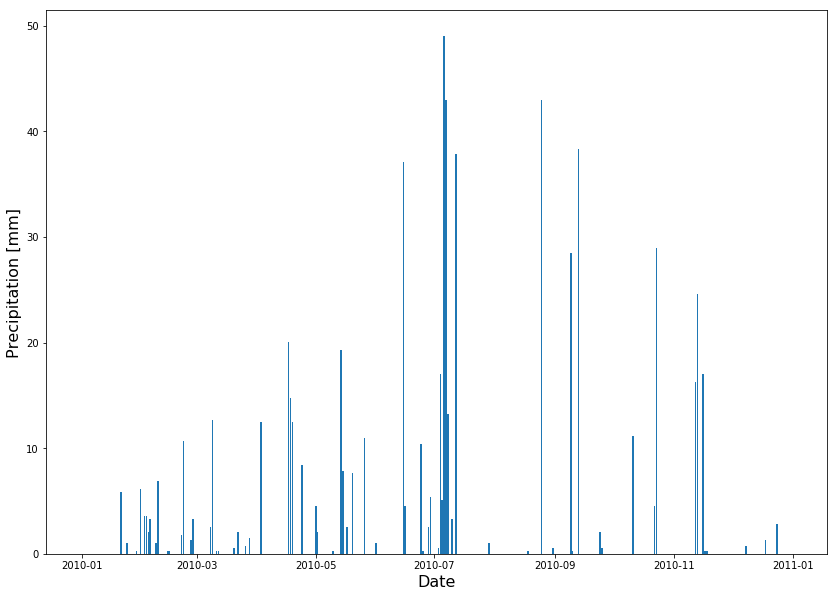

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the file name of containing the forcing data
metfile = 'soil_moisture_OK.csv'

# Define time step
dt = 1.0

# Define initial conditions
W1_0 = 10.0  # [mm]
W2_0 = 90.0  # [mm]
W3_0 = 125.0 # [mm]

# Store the initial conditions in a numpy array
W0 = np.empty(3)
W0[0] = W1_0
W0[1] = W2_0
W0[2] = W3_0

# Define parameters 
k12   = 0.10  # [day^-1]
k23   = 0.05  # [day^-1]
k3    = 0.02  # [day^-1]
W1max = 30.0  # [mm]
W2max = 175.0 # [mm]
W3max = 250.0 # [mm]
beta  = 2.0   # [-]
rf1   = 0.5   # [%]   Evaporation fraction
rf2   = 0.5   # [%]   Transpiration fraction

# Store the parameters in a numpy array
phi = np.empty(9)
phi[0] = k12
phi[1] = k23
phi[2] = k3
phi[3] = W1max
phi[4] = W2max
phi[5] = W3max
phi[6] = beta
phi[7] = rf1
phi[8] = rf2

# Load the meteorological file 
df = pd.read_csv(metfile, names=['Y','M','D','P','SM2','SM4','SM8','SM20','SM40'], skiprows=1)

# Compute a serial date and append it to the data frame
df['SerDates'] = pd.to_datetime(df.Y*10000+df.M*100+df.D,format='%Y%m%d')

# Plot the precipitation
plt.figure(figsize=(14,10))
plt.bar(df['SerDates'].values,df['P'].values)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Precipitation [mm]', fontsize=16)
plt.show()

## 2. Define the Derivatives Function: the Model Dynamics

In [5]:
# derivative function

def derivs(W,phi,U,dt):

    # Retrieve states, parameters, and forcings from input vectors
    W1 = W[0] 
    W2 = W[1]
    W3 = W[2]
    
    k12   = phi[0]
    k23   = phi[1]
    k3    = phi[2]
    W1max = phi[3]
    W2max = phi[4]
    W3max = phi[5]
    beta  = phi[6]
    rf1   = phi[7]
    rf2   = phi[8]
    
    P  = U[0]
    ET = U[1]
    
    # Create containers to store return values in
    q = np.zeros(5)
    dWdt = np.zeros(3)
    
    # Compute direct runoff using
    qdro = P*(W1/W1max)**beta     # direct runoff = P*(%saturation)^beta
    qinf = P - qdro               # infiltration = precip - direct runoff
    
    # Compute between-bucket fluxes
    q12 = np.minimum(k12*W1*dt,W1max - W1)
    q23 = np.minimum(k23*W2*dt,W2max - W2)
    q3  = np.minimum(k3*W3*dt,W3max - W3)
    
    # Compute derivatives
    dW1dt = qinf - (q12 + ET*rf1)
    dW2dt = q12 - (q23 + ET*rf2)
    dW3dt = q23 - q3
    
    # Store computed values in storage containers
    q[0] = qdro          # q direct runoff
    q[1] = qinf          # q infiltration
    q[2] = q12           
    q[3] = q23
    q[4] = q3
    
    dWdt[0] = dW1dt
    dWdt[1] = dW2dt
    dWdt[2] = dW3dt
    
    return q, dWdt;

## 3. Define the Runge-Kutta 4 Integration Function

In [7]:
# Runga-Kutta 4 function

def rk4(Wt,phi,U,dt):
    
    # Get the estimates of the slope required by the RK4 scheme - using previously created derivs function
    flux1, k1 = derivs(Wt,phi,U,dt)
    flux2, k2 = derivs(Wt+k1*dt/2,phi,U,dt)
    flux3, k3 = derivs(Wt+k2*dt/2,phi,U,dt)
    flux4, k4 = derivs(Wt+k3*dt,phi,U,dt)
    
    # Estimate the value of the state at t+dt based on the RK4 slope 
    # estimates computed above
    Wtp1 = Wt + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    
    # Call the derivs function one more time to get the values of the
    # fluxes given the new estimate of the state
    qtp1, dWtp1dt = derivs(Wtp1,phi,U,dt)
    
    return Wtp1, qtp1, dWtp1dt;

## 4. Create Storage Containers to Store Simulated Values

In [10]:
# Retrieve precipitation
P = df['P'].values

# Get length of precipitation vector - (number of times)
Nt = P.size

# Create storage containers for simulated states and fluxes
W    = np.zeros((3,Nt))
q    = np.zeros((5,Nt))
dWdt = np.zeros((3,Nt))

# Create storage container
U = np.empty(2)

# Compute the fluxes and derivatives associated with the initial conditions and store them
U[0] = P[0]
U[1] = 0.0

q0, dW0dt = derivs(W0,phi,U,dt)

# Store the initial values in the simulation storage containers
W[:,0] = W0
q[:,0] = q0
dWdt[:,0] = dW0dt

## 5. Perform the Main Simulation Loop

In [11]:

# Perform the main simulation loop
for t in np.arange(1,Nt,1):
    Wt = W[:,t-1]
    U[0] = P[t]
    U[1] = 0.0
    
    # Call the Runge-Kutta 4 iteration scheme
    Wtp1, qtp1, dWtp1dt = rk4(Wt,phi,U,dt)
    
    W[:,t] = Wtp1
    q[:,t] = qtp1
    dWdt[:,t] = dWtp1dt

## 6. Plot the results

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


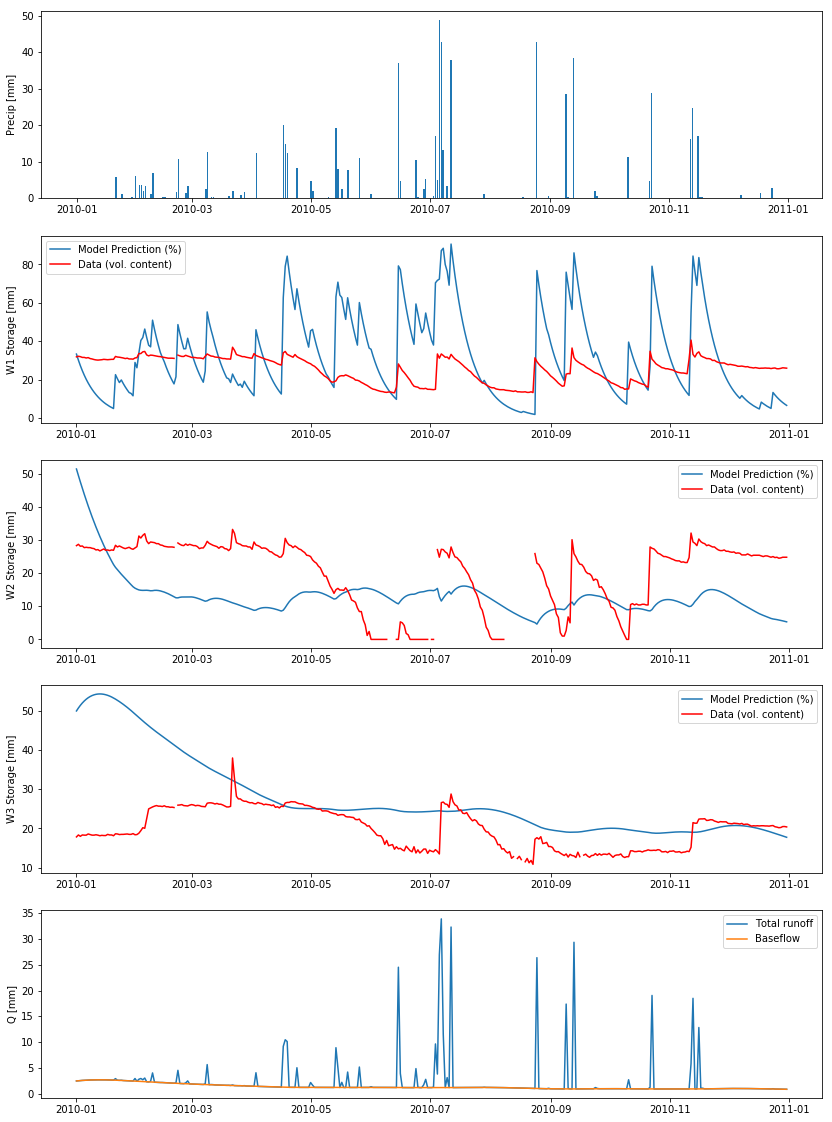

In [21]:
SM2 = df['SM2'].values
SM2[SM2 < 0.0] = np.nan

SM8 = df['SM8'].values
SM8[SM8 < 0.0] = np.nan

SM20 = df['SM20'].values
SM20[SM20 < 0.0] = np.nan

SM40 = df['SM40'].values
SM40[SM40 < 0.0] = np.nan

# Plot simulation results
plt.figure(figsize=(14,20))
plt.subplot(511)
plt.bar(df['SerDates'].values,df['P'].values)
plt.ylabel('Precip [mm]')
plt.subplot(512)
plt.plot(df['SerDates'].values,W[0,:]/W1max*100)     # percentage of storage used
plt.plot(df['SerDates'].values,SM2,'r-')
plt.ylabel('W1 Storage [mm]')
plt.legend(('Model Prediction (%)', 'Data (vol. content)'))
plt.subplot(513)
plt.plot(df['SerDates'].values,W[1,:]/W2max*100)     # percentage of storage used
plt.plot(df['SerDates'].values,SM8,'r-')
plt.ylabel('W2 Storage [mm]')
plt.legend(('Model Prediction (%)', 'Data (vol. content)'))
plt.subplot(514)
plt.plot(df['SerDates'].values,W[2,:]/W3max*100)     # percentage of storage used
plt.plot(df['SerDates'].values,(SM20+SM40)/2,'r-')
plt.ylabel('W3 Storage [mm]')
plt.legend(('Model Prediction (%)', 'Data (vol. content)'))
plt.subplot(515)
plt.plot(df['SerDates'].values,q[4,:] + q[0,:])
plt.plot(df['SerDates'].values,q[4,:])
plt.ylabel('Q [mm]')
plt.legend(('Total runoff','Baseflow'))
plt.show()